In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from cluster_local import ClusterLensing_fyp
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

In [7]:
# inject data

scenarios = {
    '1': 'abell370',
    '2': 'abell2744',
    '3': 'abells1063',
    '4': 'macs0416',
    '5': 'macs0717',
    '6': 'macs1149'
}

full_cluster_names = {
    'abell370': 'Abell 370',
    'abell2744': 'Abell 2744',
    'abells1063': 'Abell S1063',
    'macs0416': 'MACS J0416.1-2403',
    'macs0717': 'MACS J0717.5+3745',
    'macs1149': 'MACS J1149.5+2223'
}

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_psi.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi:
        datax = hdulx[0].data
        datay = hduly[0].data
        data_psi = hdul_psi[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)

# Example: Access the first datax array
print(f"Length of the first datax array: {len(datax_list[1])}")

Length of the first datax array: 678


In [8]:
# getting the pixel scale list
def get_pixscale(cluster_name, file_path='GCdata/pixsize'):
    full_path = os.path.join(file_dir, file_path)
    with open(full_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith(cluster_name):
                # Split the line to get the value after the colon and return it as a float
                return float(line.split(':')[1].strip())
    return None  # Return None if the cluster name isn't found

pixscale_list = []
for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]
    pixscale = get_pixscale(full_cluster_name)
    pixscale_list.append(pixscale)
print(pixscale_list)

[0.2, 0.25, 0.25, 0.2, 0.2, 0.2]


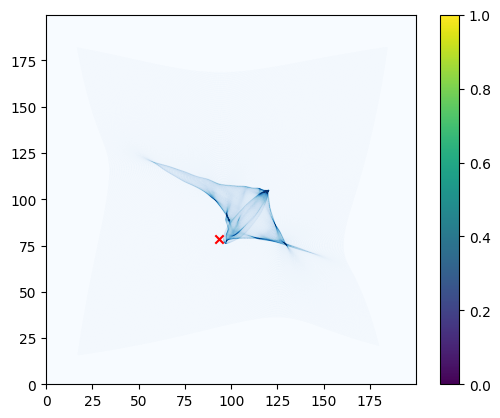

In [9]:
# look at the caustic
index = 2


size = len(datax_list[index])

array_test = np.zeros((size,size))
pixscale = pixscale_list[index]
datay = datay_list[index]/pixscale
datax = datax_list[index]/pixscale
for i in range(0,size):
    for j in range(0,size):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor,xfloor] += 1

plt.imshow(array_test, cmap='Blues', vmax = 50, extent=[0, size*pixscale, pixscale*size,0 ])
plt.scatter(93.5510851154445,78.73123076341057, c = 'r', marker='x')
plt.gca().invert_yaxis()
plt.colorbar()

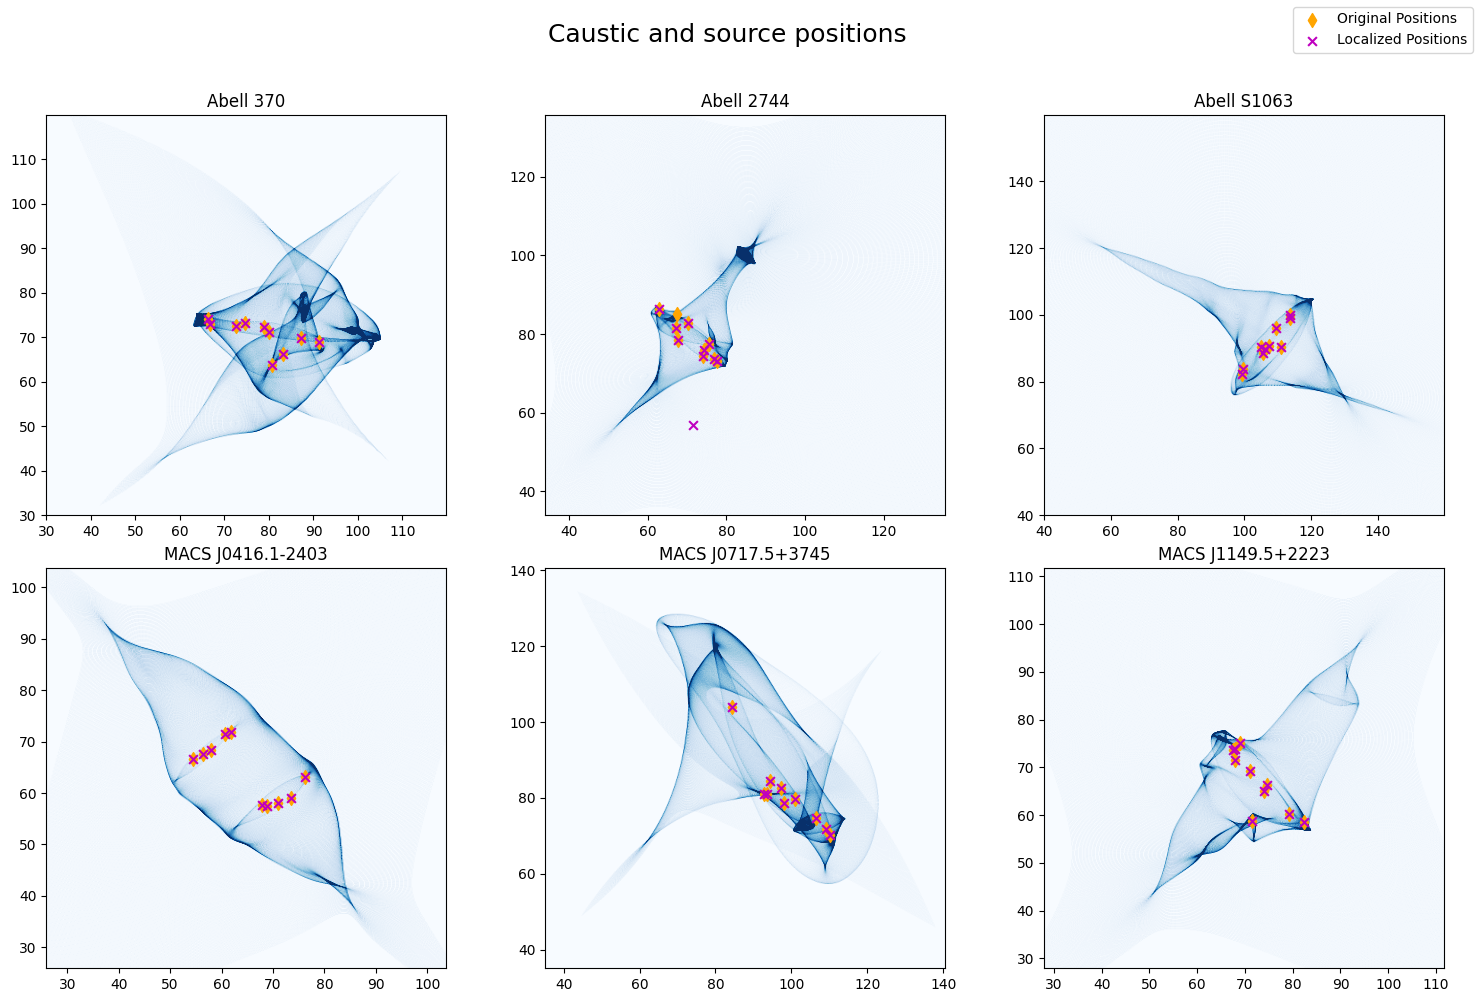

In [10]:
# make 6 graphs of the caustic
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Caustic and source positions', fontsize=18)
for i, ax in enumerate(axs.flat):
    size = len(datax_list[i])
    array_test = np.zeros((size, size))
    pixscale = pixscale_list[i]
    datay = datay_list[i] / pixscale
    datax = datax_list[i] / pixscale
    for j in range(0, size):
        for k in range(0, size):
            ycoord = j - datay[j, k]
            xcoord = k - datax[j, k]
            ydec = ycoord % 1
            xdec = xcoord % 1
            xfloor = floor(xcoord)
            yfloor = floor(ycoord)
            array_test[yfloor, xfloor] += 1
    ax.imshow(array_test, cmap='Blues', vmax=50, extent=[0, size * pixscale, pixscale * size, 0])
    ax.set_title(full_cluster_names[scenarios[str(i + 1)]])

    # Calculate new limits
    x_center = size * pixscale / 2
    y_center = size * pixscale / 2
    x_range = size * pixscale * 0.6
    y_range = size * pixscale * 0.6

    ax.set_xlim(x_center - x_range / 2, x_center + x_range / 2)
    ax.set_ylim(y_center + y_range / 2, y_center - y_range / 2)

    # Invert the y-axis
    ax.invert_yaxis()

    # Load the source positions from the CSV file
    src_pos_df = pd.read_csv('src_pos_for_distribution_2nd.csv')

    # Extract the (x, y) and (localized_x, localized_y) for the current cluster
    cluster_indices = src_pos_df[src_pos_df['indices'] == i]
    guess_indices = cluster_indices['localized_index'].values
    x = cluster_indices['x'].values
    y = cluster_indices['y'].values
    localized_x = cluster_indices['localized_x'].values
    localized_y = cluster_indices['localized_y'].values

    # Plot the extracted positions on the current cluster's caustic plot
    ax.scatter(x, y, c='orange', marker='d', label='Original Positions', s=50)
    ax.scatter(localized_x, localized_y, c='m', marker='x', label='Localized Positions', s=40)
    

# Add a general legend for all the graphs
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.figtext(0.5, -0.06, 'Figure 2: Plots for stimulated and optimized source positions after localization for each cluster. All the orange and magenta labels of the source positions\nare overlapping each other except one, which indicates that the optimized result is very close to true source positions most of the time.', ha='center', fontsize=14)
plt.show()

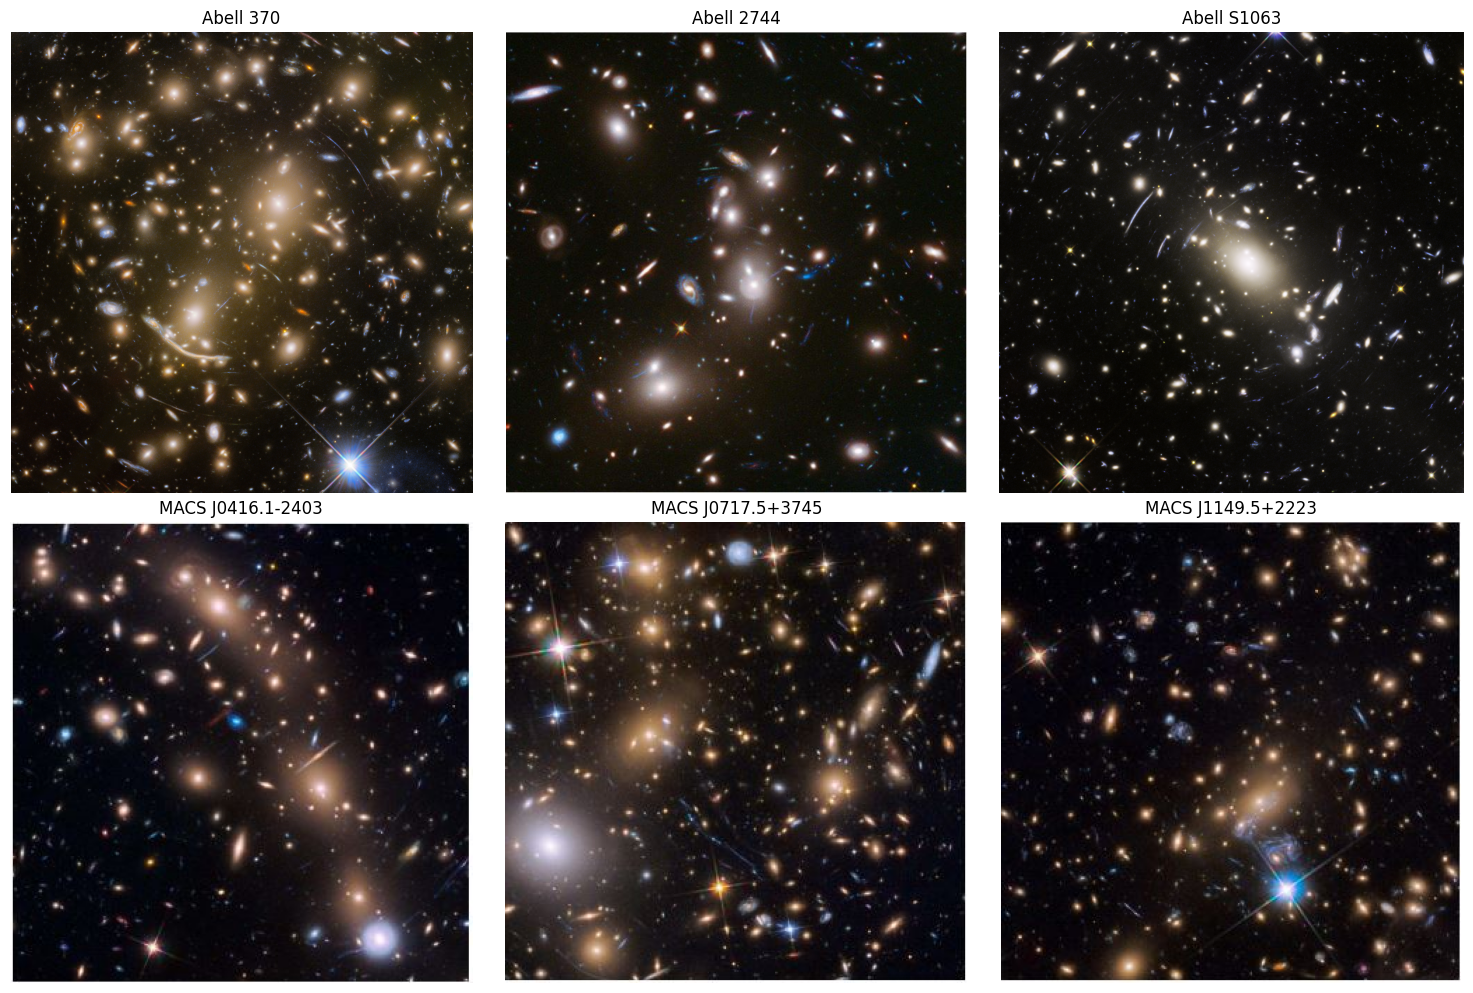

In [4]:
from PIL import Image

# List of image filenames
image_filenames = ['Report images/illustration 370.jpg','Report images/illustration 2744.JPG','Report images/illustartion s1063.tif', 
                   'Report images/illustration j0416.JPG', 'Report images/illustration j0717.JPG', 'Report images/illustration j1149.JPG']

# Number of rows and columns
rows = 2
cols = 3

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
description = ['Abell 370', 'Abell 2744', 'Abell S1063', 'MACS J0416.1-2403', 'MACS J0717.5+3745', 'MACS J1149.5+2223']

# Iterate over the images and axes
for idx, ax in enumerate(axes.flat):
    # Open the image
    img = Image.open(image_filenames[idx])
    # Display the image on the axes
    ax.imshow(img)
    ax.set_title(description[idx])
    # Remove axis ticks
    ax.axis('off')

# Adjust spacing
plt.tight_layout()
#plt.figtext(0.5, -0.03, 'Figure 1: Full depth images of galaxy clusters with multi-band color for illustration.', ha='center', fontsize=14)

# Show the plot
plt.show()